# Who guards the guards?

NBA teams value lockdown defenders -- a player who can keep their opponent's star from controlling the game. Although some defensive specialists are widely recognized around the league, and may play extensively despite limited offensive games, others may be overlooked.

### The current stats landscape

In addition, the stats that are currently available to quantify defense are either basic (but public) or sophisticated but proprietary. In the former category, we have models based on complex configurations of the basic box-score stats: John Hollinger's PER; Dean Oliver's DRtg, which is used in Justin Kubatko's Win Shares; and Daniel Myers's Boxscore Plus/Minus. In the latter, the NBA has real-time player-tracking video systems maintained in all of its arenas, and presumably grants teams and other partners access to enormous volumes of granular data. 

The league has released some measures derived from this data, abstracted up a couple levels, at stats.nba.com, and I think there's an opportunity to develop some new public metrics that go beyond what's in the box score. (Note that box-score-based metrics are important because they allow historic comparisons to other eras -- the limited inputs are a feature for many research questions, while the Second Spectrum tracking data only started with the 2017-18 season.)

### This project

In this notebook, I'll use publicly-released data from the NBA to identify the players most frequently tasked with challenging defensive assignments -- limited to guards for now -- and look at some related questions, like:
- Does top-defender-dom persist from year to year?
- How are teams with two important offensive players defended? How do teams with two top defenders assign them?
- How do these matchups change in the playoffs?

## What's our universe of "important offensive players"?

We're going to start by using a Usage leaderboard, which reflects the proportion of a team's possessions in which that player was last to touch the ball (either by shooting it or turning it over). Because turnovers are most likely when a player is either dribbling the ball or passing the ball, this component is a reasonable approximation for players who spend the most time handling the ball, even if they don't shoot as often themselves.

We could consider incorporating Assist Ratio, which is the proportion of possessions for which that player receives credit for an assist (the last pass leading directly to a made shot), but assists are noisier than the components of usage. For one, assists are determined subjectively by official scorekeepers on the basis of whether that last pass was sufficiently proximate to the shot -- scorekeepers are tied to an arena and have been demonstrated to show a bias in awarding more assists to the home team. In addition, two passes of equal quality will not be treated identically because assists are only awarded if the shot is made, so a miss (or a shooting foul drawn) can't be assisted. As a result, Assist Ratio is dependent on whether the game is home or on the road, and on the shooting ability of a player's teammate (and to a smaller extent on the skill of the defender guarding that teammate). So we'll set it aside for now.

In addition, we'll focus on Guards for now -- we want a relatively homogeneous pool of offensive players so that a standout defender is likely to be matched up against most or all of them. In particular, a player who can match up against a point guard could also handle other perimeter players but not necessarily centers.

In [1]:
# Our first step will be to pull a leaderboard for Usage from stats.nba.com and turn it into a pandas dataframe.
# Here, I'm following the workflow helpfully laid out by Greg Reda (http://www.gregreda.com/2015/02/15/web-scraping-finding-the-api/)
# and Savvas Tjortjoglu (http://savvastjortjoglou.com/nba-shot-sharts.html) that they used to obtain other sets of stats from the same site.

import requests
import pandas as pd
import numpy as np
import seaborn as sns
from time import sleep
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_rows = 20
pd.options.display.max_columns = 24

In [2]:
# we'll save the URL as a string first

# this gets us a regular-season data from 2018-19 in JSON format; 
# the MeasureType=Advanced parameter gets us the Usage stat, among others
usage_url = 'https://stats.nba.com/stats/leaguedashplayerstats?College=&Conference=&Country='+ \
                '&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&GameSegment=&Height='+ \
                '&LastNGames=0&LeagueID=00&Location=&MeasureType=Advanced&Month=0&OpponentTeamID=0'+ \
                '&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience='+ \
                '&PlayerPosition=G&PlusMinus=N&Rank=N&Season=2018-19&SeasonSegment=&SeasonType=Regular+Season'+ \
                '&ShotClockRange=&StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision=&Weight='

The server won't accept the request using the default parameters from requests.get(), so we need to send what it sees when I load the page manually (the headers).
I'm not super-confident how this conforms to the TOS for the NBA Stats site, so I'm going to endeavor to send a minimal number of GET requests, at least, no more than I would use when playing around with the full site.

In [3]:
http_headers = {'Accept': 'application/json', 'x-nba-stats-token': 'true', 'X-NewRelic-ID': 'VQECWF5UChAHUlNTBwgBVw==',
                'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.131',
                'x-nba-stats-origin': 'stats', 'Referer': 'https://stats.nba.com/players/advanced/?sort=USG_PCT&dir=-1&CF=GP*G*5:MIN*G*20&Season=2018-19&SeasonType=Regular%20Season'}

usage_output = requests.get(usage_url, headers=http_headers)


In [4]:
# now take that JSON output and turn it into a dataframe
headers1 = usage_output.json()['resultSets'][0]['headers']
players1 = usage_output.json()['resultSets'][0]['rowSet']

usage_df = pd.DataFrame(players1, columns=headers1)

print(usage_df.shape)
print(list(usage_df))

(263, 73)
['PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'AGE', 'GP', 'W', 'L', 'W_PCT', 'MIN', 'eOFF_RATING', 'OFF_RATING', 'sp_work_OFF_RATING', 'eDEF_RATING', 'DEF_RATING', 'sp_work_DEF_RATING', 'eNET_RATING', 'NET_RATING', 'sp_work_NET_RATING', 'AST_PCT', 'AST_TO', 'AST_RATIO', 'OREB_PCT', 'DREB_PCT', 'REB_PCT', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'USG_PCT', 'ePACE', 'PACE', 'sp_work_PACE', 'PIE', 'FGM', 'FGA', 'FGM_PG', 'FGA_PG', 'FG_PCT', 'GP_RANK', 'W_RANK', 'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'eOFF_RATING_RANK', 'OFF_RATING_RANK', 'sp_work_OFF_RATING_RANK', 'eDEF_RATING_RANK', 'DEF_RATING_RANK', 'sp_work_DEF_RATING_RANK', 'eNET_RATING_RANK', 'NET_RATING_RANK', 'sp_work_NET_RATING_RANK', 'AST_PCT_RANK', 'AST_TO_RANK', 'AST_RATIO_RANK', 'OREB_PCT_RANK', 'DREB_PCT_RANK', 'REB_PCT_RANK', 'TM_TOV_PCT_RANK', 'EFG_PCT_RANK', 'TS_PCT_RANK', 'USG_PCT_RANK', 'ePACE_RANK', 'PACE_RANK', 'sp_work_PACE_RANK', 'PIE_RANK', 'FGM_RANK', 'FGA_RANK', 'FGM_PG_RANK', 'FGA_PG_RANK', 'FG_




This has the stats we want, but includes plenty of players we aren't interested in, so we'll apply a couple filters to eliminate guys who played a limited number of games (or minutes per game), and then pare down to the Usage leaders based on a threshold -- between 20% (if each team shared the ball perfectly) and 30% (the 10th-highest player in the league).

In [5]:
# now we'll implement our filters -- a threshold of 24% gives us 30 players, an average of one per team
usage_leaders = usage_df.loc[(usage_df['MIN'] >= 24.0) & (usage_df['GP'] >= 20) & (usage_df['USG_PCT'] >= .24)]

print(usage_leaders.shape)
print(usage_leaders.head())

(30, 73)
    PLAYER_ID       PLAYER_NAME     TEAM_ID TEAM_ABBREVIATION   AGE  GP   W  \
19     203078      Bradley Beal  1610612764               WAS  25.0  82  32   
25    1627741       Buddy Hield  1610612758               SAC  26.0  82  39   
27     203468       CJ McCollum  1610612757               POR  27.0  70  43   
35    1629012     Collin Sexton  1610612739               CLE  20.0  82  19   
39    1626156  D'Angelo Russell  1610612751               BKN  23.0  81  42   

     L  W_PCT   MIN  eOFF_RATING  OFF_RATING         ...          \
19  50  0.390  36.9        110.1       111.3         ...           
25  43  0.476  31.9        108.8       109.0         ...           
27  27  0.614  33.9        113.7       114.8         ...           
35  63  0.232  31.8        104.5       105.2         ...           
39  39  0.519  30.2        106.9       107.2         ...           

    USG_PCT_RANK  ePACE_RANK  PACE_RANK  sp_work_PACE_RANK  PIE_RANK  \
19            14          71       

# Who guards those players?

In [6]:
# now we take the list of important offensive players' player IDs
offensive_list = usage_leaders['PLAYER_ID'].tolist()

print(offensive_list[0:5])
print(len(offensive_list))
# note that these appear as integers, and they're in first-name alpha order

[203078, 1627741, 203468, 1629012, 1626156]
30


Let's start with one important offensive player (possibly the most important offensive player, certainly as judged by Usage), James Harden, and see what we're looking at.

In [7]:
# and use it as the source for a new query to stats.nba.com to get the list of players they matched up against
# we'll start with a single example (James Harden) and then generalize to the list

matchup_url = 'https://stats.nba.com/stats/leagueseasonmatchups?DateFrom=&DateTo=&LeagueID=00&OffPlayerID=' + \
              str(201935) + '&Outcome=&PORound=0&PerMode=Totals&Season=2018-19&SeasonType=Regular+Season'

http_headers2 = {'Accept': 'application/json', 'x-nba-stats-token': 'true', 'X-NewRelic-ID': 'VQECWF5UChAHUlNTBwgBVw==',
                'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.131',
                'x-nba-stats-origin': 'stats', 'Referer': 'https://stats.nba.com/player/' + str(201935) + '/matchups/?Season=2018-19&SeasonType=Regular%20Season&PerMode=Totals'}

matchup_output = requests.get(matchup_url, headers=http_headers2)

headers2 = matchup_output.json()['resultSets'][0]['headers']
players2 = matchup_output.json()['resultSets'][0]['rowSet']

harden_df = pd.DataFrame(players2, columns=headers2)

print(harden_df.head())
print("James harden played 78 games this year, and we have "+ str(harden_df['POSS'].sum()) +\
      " possessions worth of matchup data for him, or "+ (str(harden_df['POSS'].sum()/78))[:5] +" per game.")

   OFF_TEAM_ID OFF_TEAM_ABBREVIATION OFF_TEAM_CITY OFF_TEAM_NICKNAME  \
0   1610612745                   HOU       Houston           Rockets   
1   1610612745                   HOU       Houston           Rockets   
2   1610612745                   HOU       Houston           Rockets   
3   1610612745                   HOU       Houston           Rockets   
4   1610612745                   HOU       Houston           Rockets   

   OFF_PLAYER_ID OFF_PLAYER_NAME  DEF_TEAM_ID DEF_TEAM_ABBREVIATION  \
0         201935    James Harden   1610612760                   OKC   
1         201935    James Harden   1610612740                   NOP   
2         201935    James Harden   1610612762                   UTA   
3         201935    James Harden   1610612742                   DAL   
4         201935    James Harden   1610612756                   PHX   

   DEF_TEAM_CITY DEF_TEAM_NICKNAME  DEF_PLAYER_ID      DEF_PLAYER_NAME  \
0  Oklahoma City           Thunder         202331          Paul Ge

This looks good! James Harden played 4 games against OKC, New Orleans, Dallas, and Utah, and 3 against Phoenix, so he likely faced those teams' primary defenders most often. In addition, OKC and New Orleans have individual defenders who are very highly-regarded in Paul George and Jrue Holiday (both of whom matched up the most against Harden). Utah has a top-rated team defense but their top defender plays at center, while Phoenix is near the bottom of the league -- so Harden's shooting percentage (FG_PCT) and 3-point percentage (FG3_PCT) fields in those matchups seem to roughly agree with what we'd expect to see.

In addition, we can look at the bottom line of the printout -- showing we have about 74 possessions per game worth of matchup data -- and see that this API output is **complete**. James Harden averaged a little more than 36 minutes per game (and games are 48 minutes long, plus a few overtime games per season), and NBA teams play roughly 100 possessions each over the course of a game, with Harden's Houston a little slower than league average (97.9). So this is exactly what we would expect, for a dataset that includes every possession where the offensive player is on the floor, whether he touches the ball or not.

### Next:

Now, we generalize the above matchup-generating process over each offensive player in our list, to get a set of defenders who have faced at least one offensive player a non-trivial number of times.

In [8]:
# this definitely doesn't feel pythonic, so let's assume it'll get tinkered with over time
# we include some additional parameters for the season and regular vs playoffs so we can re-use the function later
def matchups(players, season='2018-19', seasontype='Regular+Season'):
    matchup_df = pd.DataFrame()

    # we iterate over the list of offensive player ids
    for id in players:
        req_url = 'https://stats.nba.com/stats/leagueseasonmatchups?DateFrom=&DateTo=&LeagueID=00&OffPlayerID=' + \
              str(id) + '&Outcome=&PORound=0&PerMode=Totals&Season='+ season +'&SeasonType='+ seasontype

        req_headers = {'Accept': 'application/json', 'Accept-Encoding': 'gzip, deflate, br', 'Accept-Language': 'en-US,en;q=0.9',
                'Connection': 'keep-alive', 'x-nba-stats-token': 'true', 'X-NewRelic-ID': 'VQECWF5UChAHUlNTBwgBVw==',
                'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.131',
                'x-nba-stats-origin': 'stats', 'x-nba-stats-token': 'true', 'Referer': 'https://stats.nba.com/player/' + str(id) + '/matchups/?Season='+ season +'&SeasonType=Regular%20Season&PerMode=Totals'}
        
        req_output = requests.get(req_url, headers=req_headers)
        
        # this prevents requests from pinging the server too quickly, which may cause it to reject the connection
        sleep(.5)

        headers = req_output.json()['resultSets'][0]['headers']
        players = req_output.json()['resultSets'][0]['rowSet']

        df = pd.DataFrame(players, columns=headers)
        
        # this limits the list to defenders who faced that offensive player a non-trivial number of times
        df = df.loc[(df['POSS'] >= 20)]
        
        # this step, in particular, will be computationally slow -- should be much faster to create a bunch
        # of dataframes with obvious names and then concat them all at once as a list of names
        matchup_df = pd.concat([matchup_df, df], ignore_index=True)
    
    return matchup_df

In [9]:
# we'll call our function
matchup_df = matchups(offensive_list)

In [10]:
# sanity check: let's see some matchups that were for exactly 20 possessions
matchup_df.loc[(matchup_df['POSS'] == 20)][0:20]

,OFF_TEAM_ID,OFF_TEAM_ABBREVIATION,OFF_TEAM_CITY,OFF_TEAM_NICKNAME,OFF_PLAYER_ID,OFF_PLAYER_NAME,DEF_TEAM_ID,DEF_TEAM_ABBREVIATION,DEF_TEAM_CITY,DEF_TEAM_NICKNAME,DEF_PLAYER_ID,DEF_PLAYER_NAME,...,HELP_BLK_REC,FGM,FGA,FGA_DIFF,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,SFL,DEF_FOULS,OFF_FOULS
92,1610612764,WAS,Washington,Wizards,203078,Bradley Beal,1610612766,CHA,Charlotte,Hornets,1628970,Miles Bridges,...,0,1,2,0.399743,0.500,0,0,0.000,2,0,0,0
178,1610612758,SAC,Sacramento,Kings,1627741,Buddy Hield,1610612744,GSW,Golden State,Warriors,201939,Stephen Curry,...,1,3,7,1.448090,0.429,1,2,0.500,0,0,0,0
179,1610612758,SAC,Sacramento,Kings,1627741,Buddy Hield,1610612745,HOU,Houston,Rockets,202697,Iman Shumpert,...,1,5,8,1.654960,0.625,3,4,0.750,0,0,0,0
180,1610612758,SAC,Sacramento,Kings,1627741,Buddy Hield,1610612748,MIA,Miami,Heat,1626159,Justise Winslow,...,0,1,7,1.448090,0.143,1,6,0.167,3,1,1,0
251,1610612757,POR,Portland,Trail Blazers,203468,CJ McCollum,1610612740,NOP,New Orleans,Pelicans,203546,Ian Clark,...,0,2,4,0.794634,0.500,1,3,0.333,0,0,1,0
252,1610612757,POR,Portland,Trail Blazers,203468,CJ McCollum,1610612762,UTA,Utah,Jazz,1626220,Royce O'Neale,...,0,1,3,0.595976,0.333,0,0,0.000,1,1,0,1
253,1610612757,POR,Portland,Trail Blazers,203468,CJ McCollum,1610612747,LAL,Los Angeles,Lakers,2544,LeBron James,...,0,1,2,0.397317,0.500,1,2,0.500,0,0,0,0
254,1610612757,POR,Portland,Trail Blazers,203468,CJ McCollum,1610612747,LAL,Los Angeles,Lakers,1628404,Josh Hart,...,0,2,6,1.191951,0.333,0,2,0.000,0,0,0,0
323,1610612739,CLE,Cleveland,Cavaliers,1629012,Collin Sexton,1610612741,CHI,Chicago,Bulls,1627885,Shaquille Harrison,...,0,3,7,1.526816,0.429,0,1,0.000,0,1,0,0
324,1610612739,CLE,Cleveland,Cavaliers,1629012,Collin Sexton,1610612759,SAS,San Antonio,Spurs,1627854,Bryn Forbes,...,1,2,3,0.654350,0.667,0,0,0.000,0,0,0,0


OK, so now we have a (very) long list of matchups between our 30 offensive players and every defender who has matched up with them on at least 20 possessions this season. We can switch our focus to the individual defenders fairly easily in pandas, by creating a groupby object.

So let's start by looking at some summary stats for our defenders to get a better feel for the matchups dataset.

In [11]:
# group and aggregate by defender (as a pandas groupby object)
defenders = matchup_df.groupby(['DEF_PLAYER_NAME'])

# explore properties of this construction of the data
df_example = defenders['GP','POSS'].agg(['count', np.sum, np.max])

df_example.head(20)

GP           POSS           
                  count sum amax count   sum amax
DEF_PLAYER_NAME                                  
Aaron Gordon          3   8    4     3   157   57
Aaron Holiday         2   5    3     2    57   35
Abdel Nader           1   2    2     1    20   20
Al-Farouq Aminu       3  10    4     3   100   49
Alec Burks           10  15    2    10   383   61
Alex Abrines          2   4    2     2    45   24
Alex Caruso           5   7    2     5   130   36
Allen Crabbe          6  15    4     6   225   90
Allonzo Trier         8  21    4     8   217   34
Andre Iguodala        9  24    4     9   274   47
Andrew Wiggins       14  44    4    14   548   80
Antonio Blakeney      1   2    2     1    21   21
Austin Rivers        21  42    3    21   805   99
Avery Bradley        28  47    3    28  1510   96
Ben Simmons          14  37    4    14   448   59
Bogdan Bogdanovic    10  29    4    10   374   81
Bojan Bogdanovic      4  10    4     4   114   47
Brad Wanamaker        2   6    3     2    80   45
Bradley Beal         24  57    4    24   989  100
Brandon Ingram       12  30    3    12   491  108

Keeping in mind that our unit of analysis is an offensive player-defensive player matchup, both of the above COUNT columns refer to the number of offensive players (from our original list of 30) that a player matched up against. So **Avery Bradley** faced just about every offensive standout in the league (and it's possible one of the other two is his teammate), while **Brandon Ingram** (who plays small forward and often guards larger players, and who missed time this season with injuries) has matchedup against about half of them.

The SUM columns tell you how many times that offense-defense matchup actually faced each other -- because the NBA has an unbalanced schedule (with teams playing divisional and conference rivals more often), and because most players don't play every game of the year, we expect some variation here. **Bradley Beal** played all 82 games this season, and accrued 57 game-matchups against offensive stars (although since some of those stars may be teammates, this may not be 57 distinct games).

The MAX columns are really just a sanity check -- it's possible for two players to meet more than four times in a regular season, but it would require one or both of them to change teams (by being traded, for example). Similarly, since a star player will be on the court for 70-80 possessions per game, and defenders don't always end up matched up against their main assignment (because their rests don't align, defensive switches, or other reasons) the maximum possessions for a given matchup tops out at 40/game (e.g., for CJ McCollum), which seems reasonable.

## Next

Let's filter this list down to generate a set of 'standout defenders' who frequently take the most difficult defensive assignments. We'll use both POSS.count, which indicates a given defender has been matched up against many of our list of 30 offensive leaders, and POSS.mean, so the defender has covered them lots of times over the course of the season.

This does introduce a little bit of bias, since the unequal schedule and non-uniform distribution of offensive leaders means **some players have a larger opportunity space than others**. In other words, it's hard to identify a standout defender if they never had a star to defend... which is a problem intrinsic to this source of data.

In [12]:
# identify a threshold value to create our list of standout defenders
some_defs = defenders.filter(lambda x: (x['POSS'].count() >= 10) and (x['POSS'].mean() >= 50))

# we create a new groupby object for the filtered list
top_defs = some_defs.groupby(['DEF_PLAYER_NAME'])

top_defs_ex = top_defs['POSS'].agg(['count', 'sum'])
print(top_defs_ex)

                   count   sum
DEF_PLAYER_NAME               
Avery Bradley         28  1510
CJ McCollum           18  1092
D'Angelo Russell      11   624
D.J. Augustin         10   803
Damian Lillard        16  1027
Darren Collison       13  1011
De'Aaron Fox          20  1315
DeMar DeRozan         11   550
Derrick White         18  1060
Eric Bledsoe          19  1711
...                  ...   ...
Josh Okogie           14  1060
Jrue Holiday          23  1424
Klay Thompson         20  1376
Kris Dunn             16   809
Nicolas Batum         17   986
Patrick Beverley      18   939
Paul George           15   945
Ricky Rubio           14  1079
Terrance Ferguson     12   795
Torrey Craig          18   945

[24 rows x 2 columns]


(0, 1800)

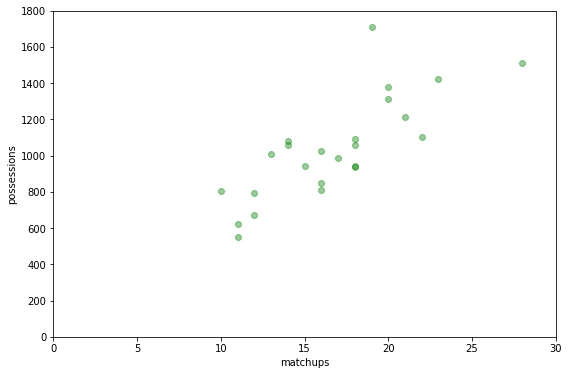

In [13]:
fig,ax = plt.subplots(1, 1, figsize=(9, 6))

# if we want an x=y line
# x = range(0,1000,10)
# ax.plot(x, x, c='r')

ax.scatter(top_defs_ex['count'], top_defs_ex['sum'], c='g', alpha=0.4)
ax.set_xlabel('matchups')
ax.set_ylabel('possessions')

# start with default axes
ax.set_xlim([0, 30])
ax.set_ylim([0, 1800])

#ax1.set_title('Possessions Defended against High-Usage Players')

In the figure above, you can clearly see our threshold values of 10 matchups (the limit to the left of the plotted points) and an average of 50 possessions per matchup (a diagonal line under the plotted points).

The outlier above the rest of the points is Eric Bledsoe of the Bucks, who defended opponents' high-usage players a greater number of possessions than anyone else this year (total, not on a per-game basis); the outlier to the right is Avery Bradley of the Clippers, who matched up against nearly every high-usage player in the league.

It turns out that the size of the output is fairly sensitive to the value we choose for POSS.mean, so we're going to start with a threshold that gives us a little fewer than 30 defenders. Hopefully this list will be closely-aligned to players with the reputation for being good defenders, which would validate this methodology (of using matchups). Then we can open up some of the parameters and look for players that may have flown under the radar.

In [14]:
# is there any overlap between the lists (two-way players)?
defs_list = some_defs['DEF_PLAYER_ID'].unique().tolist()

two_way_list = set(offensive_list).intersection(set(defs_list))
print(two_way_list)

{202691, 203081, 1626156, 203468, 201942, 201950}


In [15]:
two_way_names = some_defs['DEF_PLAYER_NAME'].loc[some_defs['DEF_PLAYER_ID'].isin(two_way_list)].unique()

print(two_way_names)

['CJ McCollum' 'Klay Thompson' 'Jrue Holiday' "D'Angelo Russell"
 'Damian Lillard' 'DeMar DeRozan']


## Is this consistent from year to year?

While we only have two seasons' worth of data, we can at least generate a scatterplot comparing those two seasons. We'll start by generating a list of defenders from the prior season, which we'll compare with the un-filtered defender list from above (so that we capture players who only took on a lot of assignments in one of the seasons).

In [16]:
# as before, but with the prior season selected
url_17 = 'https://stats.nba.com/stats/leaguedashplayerstats?College=&Conference=&Country='+ \
                '&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&GameSegment=&Height='+ \
                '&LastNGames=0&LeagueID=00&Location=&MeasureType=Advanced&Month=0&OpponentTeamID=0'+ \
                '&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience='+ \
                '&PlayerPosition=G&PlusMinus=N&Rank=N&Season=2017-18&SeasonSegment=&SeasonType=Regular+Season'+ \
                '&ShotClockRange=&StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision=&Weight='

headers_17 = {'Accept': 'application/json', 'x-nba-stats-token': 'true', 'X-NewRelic-ID': 'VQECWF5UChAHUlNTBwgBVw==',
                'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.131',
                'x-nba-stats-origin': 'stats', 'Referer': 'https://stats.nba.com/players/advanced/?sort=USG_PCT&dir=-1&CF=GP*G*5:MIN*G*20&Season=2017-18&SeasonType=Regular%20Season'}

usage_17 = requests.get(url_17, headers=headers_17)

headers17 = usage_17.json()['resultSets'][0]['headers']
players17 = usage_17.json()['resultSets'][0]['rowSet']

usage17_df = pd.DataFrame(players17, columns=headers17)



In [17]:
# verify that we get roughly similar results from the same thresholds -- 
usage17_leaders = usage17_df.loc[(usage17_df['MIN'] >= 24.0) & (usage17_df['GP'] >= 20) & (usage17_df['USG_PCT'] >= .24)]

print(usage17_leaders.shape)
print(usage17_leaders.head())

offensive17_list = usage17_leaders['PLAYER_ID'].tolist()


(28, 73)
    PLAYER_ID       PLAYER_NAME     TEAM_ID TEAM_ABBREVIATION   AGE  GP   W  \
22     203078      Bradley Beal  1610612764               WAS  25.0  82  43   
30     203468       CJ McCollum  1610612757               POR  26.0  81  48   
40    1626156  D'Angelo Russell  1610612751               BKN  22.0  48  16   
42     203081    Damian Lillard  1610612757               POR  27.0  73  44   
57     201942     DeMar DeRozan  1610612761               TOR  28.0  80  57   

     L  W_PCT   MIN  eOFF_RATING  OFF_RATING         ...          \
22  39  0.524  36.3        107.6       108.4         ...           
30  33  0.593  36.1        106.3       106.6         ...           
40  32  0.333  25.7        104.6       104.0         ...           
42  29  0.603  36.6        108.3       110.1         ...           
57  23  0.713  33.9        112.2       113.7         ...           

    USG_PCT_RANK  ePACE_RANK  PACE_RANK  sp_work_PACE_RANK  PIE_RANK  \
22            26         163       

### A couple quick notes:
- using the same Usage threshold, we get 28 players, which is close enough that I think we can keep it the same
- the AGE field appears to be a little wonky -- CJ McCollum and D'Angelo Russell show up a year younger than in the 2018-19 data, but Bradley Beal is listed as the same age in both; fortunately, we aren't using this field for anything
- we can tell this is pulling from the correct season because DeMar DeRozan changed teams between seasons (from Toronto to San Antonio), and Collin Sexton (who was on the 18-19 list but is not on this one) was a rookie this year

In [18]:
# now we generate the corresponding list of defenders -- we can re-use the function from before,
# because we included the season-year as a parameter
matchup17_df = matchups(offensive17_list, season='2017-18')

defenders17 = matchup17_df.groupby(['DEF_PLAYER_NAME'])

# explore properties of this construction of the data
defenders17['GP','POSS'].agg(['count', np.sum, np.max])[0:20]


GP           POSS          
                  count sum amax count  sum amax
DEF_PLAYER_NAME                                 
Aaron Gordon          3   6    3     3  124   71
Aaron Harrison        1   1    1     1   36   36
Al-Farouq Aminu       2   5    3     2   91   54
Alec Burks            2   6    4     2   43   23
Allen Crabbe          9  23    4     9  540  116
Andre Iguodala        7  16    4     7  232   84
Andre Roberson       10  15    3    10  405   78
Andrew Harrison      12  26    4    12  449   59
Andrew Wiggins       12  35    4    12  712  117
Anthony Davis         2   6    3     2   45   24
Anthony Tolliver      1   4    4     1   34   34
Antonio Blakeney      1   2    2     1   34   34
Austin Rivers        20  41    4    20  912   98
Avery Bradley        16  25    3    16  941  135
Ben McLemore          5  10    2     5  127   29
Ben Simmons          12  35    4    12  544  100
Blake Griffin         2   2    1     2   73   40
Bogdan Bogdanovic    12  29    4    12  447   71
Bojan Bogdanovic      5  13    4     5  486  188
Bradley Beal         17  43    4    17  693   88

In [19]:
# when we join the two seasons' lists together, we won't apply a filter/threshold, so that we can include
# rookies and players who retired.

fields = {'GP': 'count', 'POSS': np.sum}

df18 = defenders.agg(fields).rename(columns={'GP':'plr_matches18', 'POSS':'poss_18'})
df17 = defenders17.agg(fields).rename(columns={'GP':'plr_matches17', 'POSS':'poss_17'})

df_bothyrs = pd.concat([df18, df17], axis=1, join='outer', sort=True).fillna(value=0)

print("Combined, we have data for "+ str(df_bothyrs.size) +" players who defended at least one of the high-usage offensive players in either season.")
print(df_bothyrs.head())

Combined, we have data for 1312 players who defended at least one of the high-usage offensive players in either season.
                 plr_matches18  poss_18  plr_matches17  poss_17
Aaron Gordon               3.0    157.0            3.0    124.0
Aaron Harrison             0.0      0.0            1.0     36.0
Aaron Holiday              2.0     57.0            0.0      0.0
Abdel Nader                1.0     20.0            0.0      0.0
Al-Farouq Aminu            3.0    100.0            2.0     91.0


In [20]:
# The year-to-year correlation is surprisingly low.
df_bothyrs.corr()

,plr_matches18,poss_18,plr_matches17,poss_17
plr_matches18,1.000000,0.948981,0.553328,0.557994
poss_18,0.948981,1.000000,0.541481,0.569553
plr_matches17,0.553328,0.541481,1.000000,0.950226
poss_17,0.557994,0.569553,0.950226,1.000000


Text(0.5, 1.0, 'Number of High-Usage Players Defended, by Season')

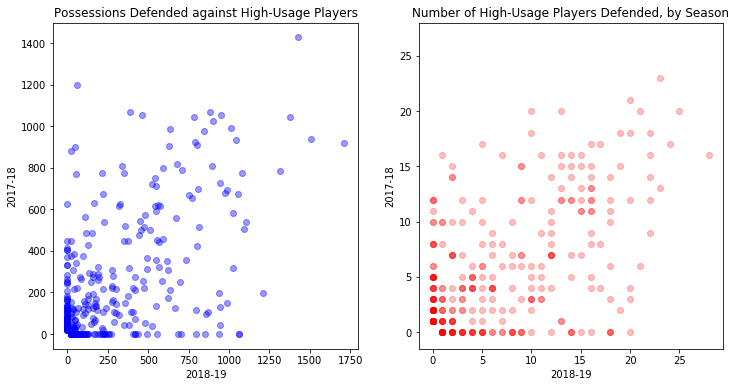

In [21]:
# plot pairwise in a scatterplot

fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(12, 6))

# if we want an x=y line
# x = range(0,1000,10)
# ax.plot(x, x, c='r')

ax1.scatter(df_bothyrs['poss_18'], df_bothyrs['poss_17'], c='b', alpha=0.4)
ax1.set_xlabel('2018-19')
ax1.set_ylabel('2017-18')

ax2.scatter(df_bothyrs['plr_matches18'], df_bothyrs['plr_matches17'], c='r', alpha=0.25)
ax2.set_xlabel('2018-19')
ax2.set_ylabel('2017-18')
ax2.set_ylim([-1.5, 28])

# start with default axes
#ax.set_xlim([50000, 20000000])
#ax.set_ylim([50000, 20000000])

ax1.set_title('Possessions Defended against High-Usage Players')
ax2.set_title('Number of High-Usage Players Defended, by Season')



While we calculate a relatively low correlation between the two seasons when looking at all the data, we have a lot of players with very few possessions in EITHER year -- while players farther along the x- and y-axes of the plot are interesting (maybe they're rookies or changed teams), those nearest the origin are not, for our present purposes.

In [22]:
mask = (df_bothyrs['poss_17']**2 + df_bothyrs['poss_18']**2) > 40000

df_bothyrs_b = df_bothyrs[mask]
print(df_bothyrs_b.shape)

print(df_bothyrs_b.corr()) 

(188, 4)
               plr_matches18   poss_18  plr_matches17   poss_17
plr_matches18       1.000000  0.919690       0.269083  0.300655
poss_18             0.919690  1.000000       0.278742  0.342512
plr_matches17       0.269083  0.278742       1.000000  0.929115
poss_17             0.300655  0.342512       0.929115  1.000000


Text(0.5, 1.0, 'Number of High-Usage Players Defended, by Season')

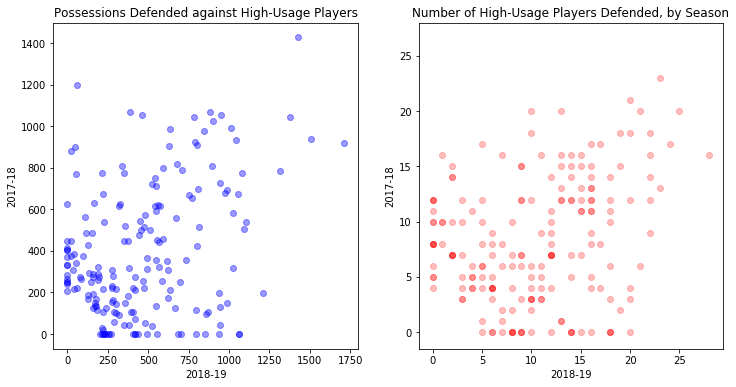

In [23]:
# plot pairwise in a scatterplot

fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(df_bothyrs_b['poss_18'], df_bothyrs_b['poss_17'], c='b', alpha=0.4)
ax1.set_xlabel('2018-19')
ax1.set_ylabel('2017-18')

ax2.scatter(df_bothyrs_b['plr_matches18'], df_bothyrs_b['plr_matches17'], c='r', alpha=0.25)
ax2.set_xlabel('2018-19')
ax2.set_ylabel('2017-18')
ax2.set_ylim([-1.5, 28])

# start with default axes
#ax.set_xlim([50000, 20000000])
#ax.set_ylim([50000, 20000000])

ax1.set_title('Possessions Defended against High-Usage Players')
ax2.set_title('Number of High-Usage Players Defended, by Season')

So this is actually even worse, if we calculate the correlation. The extreme outliers do mesh well with our intuition, but this method may not be fruitful after all.

### The Playoffs

In [24]:
# return to stats.nba.com to pull playoff data (probably 2017-18 for now)
# as before, but with the prior season selected
url_17p = 'https://stats.nba.com/stats/leaguedashplayerstats?College=&Conference=&Country='+ \
                '&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&GameSegment=&Height='+ \
                '&LastNGames=0&LeagueID=00&Location=&MeasureType=Advanced&Month=0&OpponentTeamID=0'+ \
                '&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience='+ \
                '&PlayerPosition=G&PlusMinus=N&Rank=N&Season=2017-18&SeasonSegment=&SeasonType=Playoffs'+ \
                '&ShotClockRange=&StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision=&Weight='

headers_17p = {'Accept': 'application/json', 'x-nba-stats-token': 'true', 'X-NewRelic-ID': 'VQECWF5UChAHUlNTBwgBVw==',
                'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.131',
                'x-nba-stats-origin': 'stats', 'Referer': 'https://stats.nba.com/players/advanced/?sort=USG_PCT&dir=-1&CF=GP*G*5:MIN*G*20&Season=2017-18&SeasonType=Playoffs'}

usage_17p = requests.get(url_17p, headers=headers_17p)

headers17p = usage_17p.json()['resultSets'][0]['headers']
players17p = usage_17p.json()['resultSets'][0]['rowSet']

usage17p_df = pd.DataFrame(players17p, columns=headers17p)

In [25]:
# using the same 24% USG threshold (and a minimum for minutes but not games-played), we get ~1 guard per playoff team
usage17p_leaders = usage17p_df.loc[(usage17p_df['MIN'] >= 15.0) & (usage17p_df['USG_PCT'] >= .24)]

print(usage17p_leaders.shape)
print(usage17p_leaders.head())

offensive17p_list = usage17p_leaders['PLAYER_ID'].tolist()

(17, 73)
    PLAYER_ID     PLAYER_NAME     TEAM_ID TEAM_ABBREVIATION   AGE  GP   W  L  \
7      203078    Bradley Beal  1610612764               WAS  25.0   6   2  4   
14     101108      Chris Paul  1610612745               HOU  33.0  15  11  4   
17     203081  Damian Lillard  1610612757               POR  27.0   4   0  4   
23     201942   DeMar DeRozan  1610612761               TOR  28.0  10   4  6   
26     201565    Derrick Rose  1610612750               MIN  29.0   5   1  4   

    W_PCT   MIN  eOFF_RATING  OFF_RATING        ...          USG_PCT_RANK  \
7   0.333  35.9        102.8       104.3        ...                    17   
14  0.733  34.5        107.7       107.0        ...                    18   
17  0.000  40.6        105.1       105.9        ...                    23   
23  0.400  35.4        106.5       107.6        ...                    10   
26  0.200  23.8        114.0       114.8        ...                    20   

    ePACE_RANK  PACE_RANK  sp_work_PACE_RANK  P

In [26]:
# we have at least as many games between team-pairs (because a playoff series is 4-7 games), 
# but many fewer matchups between teams (15 total, max 4 for the teams in the Finals)

matchup17p_df = matchups(offensive17p_list, season='2017-18', seasontype='Playoffs')

defenders17p = matchup17p_df.groupby(['DEF_PLAYER_NAME'])

# explore properties of this construction of the data
defenders17p['GP','POSS'].agg(['count', np.sum, np.max])[0:20]

GP           POSS          
                 count sum amax count  sum amax
DEF_PLAYER_NAME                                
Al Horford           1   7    7     1   36   36
Al-Farouq Aminu      1   4    4     1   37   37
Alex Abrines         1   6    6     1   24   24
Andre Iguodala       4  13    5     4  124   41
Andrew Wiggins       2  10    5     2   87   59
Ben Simmons          3  14    5     3  126   62
Bojan Bogdanovic     1   7    7     1  266  266
Bradley Beal         1   6    6     1   60   60
CJ McCollum          1   4    4     1   35   35
Carmelo Anthony      2  12    6     2   48   26
Chris Paul           3  15    5     3  137   66
Clint Capela         2  12    7     2   81   51
Corey Brewer         2  12    6     2  198  165
Damian Lillard       1   4    4     1   53   53
Dante Exum           2   9    5     2   82   53
Dario Saric          1   4    4     1   23   23
DeMar DeRozan        2  12    6     2   76   45
Delon Wright         2  12    6     2  126   73
Derrick Rose         2  10    5     2   91   49
Donovan Mitchell     3  16    6     3  261  130

So when we look at playoff data, we see many fewer opportunities for different player matchups (because a given team only plays, at most, four opponents). But we do see some players with a large number of recorded possessions, so there may still be some value we can wring out of it.

The biggest question, at this point, is what (if any) threshold do we want to set to include defensive players in our dataset? Possibly because of changes in defensive scheme or tactical considerations (teams can do more opponent-centric game planning in the playoffs), we see centers like Al Horford, Clint Capela, and Dario Saric in our list of defenders. This is most likely the result of an early switch -- when a team runs a screening play, sometimes the defense swaps assignments and leaves a center on a guard (and vice versa) -- or a fast-break possession, when the defense is scrambling and can't reach their preferred matchups. These matchups are likely the result of the offense doing something it wants to, in other words, rather than the defense deliberately seeking them out.

In [31]:
# let's start, then, with a leaderboard
cols = {'GP':np.sum, 'POSS':[np.sum,np.max]}
df_leaders_17p = defenders17p.agg(cols)

df_leaders_17p.rename(columns={'(GP, sum)':'games17p', '(POSS, sum)':'ttl_poss17p', '(POSS, amax)':'max_poss17p'})
df_leaders_17p.head()

GP POSS     
                sum  sum amax
DEF_PLAYER_NAME              
Al Horford        7   36   36
Al-Farouq Aminu   4   37   37
Alex Abrines      6   24   24
Andre Iguodala   13  124   41
Andrew Wiggins   10   87   59

In [ ]:

# look to see if the following patterns hold:
# - ability of defenders to retain their matchups (more switching)
# - new names (Iguodala)?